In [2]:
from pathlib import Path
from typing import List, Dict, Optional
import json
from pyang import repository, context, statements

In [3]:
# --- CONFIG -------------------------------------------------------------------

BASE_DIR = Path("yang/vendor/cisco/xr/701").resolve()
OUT_JSON = Path("sensor_catalog.jsonl").resolve()

MIN_LEAVES = 2        # require at least this many distinct leaf names under a subtree
MAX_DEPTH: Optional[int] = None  # or an int like 6 to limit how deep we go

print("YANG base:", BASE_DIR)
print("Output JSONL:", OUT_JSON)

YANG base: /home/musel/Documents/github/rag-telemetry-config/yang/vendor/cisco/xr/701
Output JSONL: /home/musel/Documents/github/rag-telemetry-config/sensor_catalog.jsonl


In [4]:
# --- YANG LOADING -------------------------------------------------------------

def load_modules(base_dir: Path):
    """Parse all .yang files under base_dir with pyang."""
    repo = repository.FileRepository(str(base_dir))
    ctx = context.Context(repo)

    modules: List[statements.Statement] = []
    for p in base_dir.rglob("*.yang"):
        try:
            text = p.read_text(encoding="utf-8", errors="ignore")
            mod = ctx.add_module(p.name, text)
            if mod is not None:
                modules.append(mod)
        except Exception as e:
            print(f"[WARN] Failed to parse {p}: {e}")
    ctx.validate()
    return ctx, modules

In [5]:
# --- SAFE TREE WALK HELPERS ---------------------------------------------------

def iter_children(s: statements.Statement):
    """Safe iterator over data children (i_children may not exist on leaves)."""
    ch = getattr(s, "i_children", None)
    return ch if ch is not None else []


def is_container_or_list(stmt: statements.Statement) -> bool:
    return stmt.keyword in ("container", "list")


def is_leaf(stmt: statements.Statement) -> bool:
    return stmt.keyword in ("leaf", "leaf-list")


def collect_leaf_names(stmt: statements.Statement) -> List[str]:
    """Collect distinct leaf/leaf-list names under a subtree."""
    names: set[str] = set()

    def _walk(s: statements.Statement):
        if is_leaf(s):
            names.add(s.arg)
            return
        for ch in iter_children(s):
            _walk(ch)

    _walk(stmt)
    return sorted(names)




In [6]:
# --- SEMANTIC TAGGING ---------------------------------------------------------
def guess_protocol_tag(module_name: str, path: str) -> Optional[str]:
    """Heuristic mapping from module/path to protocol tag."""
    s = (module_name + ":" + path).lower()
    
    mapping = [
        ("bgp", "bgp"),
        ("ospf", "ospf"),
        ("isis", "isis"),
        ("mpls", "mpls"),
        ("ldp", "ldp"),
        ("pim", "multicast"),
        ("igmp", "multicast"),
        ("rib", "routing"),
        ("route", "routing"),
        ("ifmgr", "interfaces"),
        ("ipv4-if", "interfaces"),
        ("ipv6-if", "interfaces"),
        ("interface", "interfaces"),
        ("qos", "qos"),
        ("acl", "acl"),
        ("infra", "platform"),
        ("platform", "platform"),
        ("bfd", "bfd"),
        ("tunnel", "tunnel"),
        ("ip-ma", "tunnel"),
        ("gre", "tunnel"),
        ("l2tun", "tunnel"),
        ("vxlan", "tunnel"),
        ("ethernet", "l2"),
        ("l2vpn", "l2"),
        ("bridge-domain", "l2"),
        ("mac", "l2"),
        ("arp", "neighbor"),
        ("neighbor", "neighbor"),
        ("ntp", "timing"),
        ("ptp", "timing"),
        ("clock", "timing"),
        ("aaa", "security"),
        ("crypto", "security"),
        ("ssh", "security"),
        ("telemetry", "telemetry"),
        ("mdt", "telemetry"),
        ("process", "system"),
        ("memory", "system"),
        ("cpu", "system"),
    ]
    
    for key, tag in mapping:
        if key in s:
            return tag

    return None

def guess_categories(path: str, leaf_names: List[str]) -> List[str]:
    """Heuristic 'what is this subtree about?' tags."""
    tags: set[str] = set()
    p = path.lower()
    leaves_str = " ".join(leaf_names).lower()

    def add_if(substr: str, tag: str, haystack: str):
        if substr in haystack:
            tags.add(tag)

    # Path-based hints
    add_if("neighbor", "neighbors", p)
    add_if("peer", "neighbors", p)
    add_if("process", "process", p)
    add_if("session", "sessions", p)
    add_if("interface", "interfaces", p)
    add_if("intf", "interfaces", p)
    add_if("rib", "routes", p)
    add_if("route", "routes", p)
    add_if("prefix", "prefixes", p)
    add_if("traffic", "traffic", p)
    add_if("counter", "stats", p)
    add_if("alarm", "alarms", p)
    add_if("event", "events", p)
    add_if("tunnel", "tunnels", p)
    add_if("bfd", "bfd", p)

    # Leaf-name-based hints
    if any(x in leaves_str for x in ["state", "status", "up", "down", "admin-state", "oper-state"]):
        tags.add("state")
    if any(x in leaves_str for x in ["packets", "octets", "bytes", "drops", "errors", "counter"]):
        tags.add("stats")
    if any(x in leaves_str for x in ["utilization", "usage", "percent"]):
        tags.add("utilization")

    # Fallback
    if not tags:
        tags.add("state")

    return sorted(tags)


In [7]:
# --- TRAVERSAL & CATALOG BUILDING --------------------------------------------

def build_path(module_name: str, ancestors: List[str], current: str) -> str:
    """Canonical XR sensor path: Module:elem1/elem2/..."""
    elems = ancestors + [current]
    return f"{module_name}:{'/'.join(elems)}"


def traverse_module(mod: statements.Statement,
                    min_leaves: int = 1,
                    max_depth: Optional[int] = None) -> List[Dict]:
    """
    Extract candidate sensor paths for a single module.

    Criteria:
      - Consider all container/list subtrees
      - Keep those with >= min_leaves distinct leaf names
      - Ignore config vs state here (we already filter to *-oper.yang modules)
    """
    module_name = mod.arg
    results: List[Dict] = []

    def _walk(stmt: statements.Statement, ancestors: List[str], depth: int):
        if max_depth is not None and depth > max_depth:
            return

        if is_container_or_list(stmt):
            leaf_names = collect_leaf_names(stmt)
            leaf_count = len(leaf_names)
            if leaf_count >= min_leaves:
                desc_stmt = stmt.search_one("description")
                desc = (desc_stmt.arg.strip() if desc_stmt and desc_stmt.arg else "")
                path = build_path(module_name, ancestors, stmt.arg)
                protocol_tag = guess_protocol_tag(module_name, path)
                categories = guess_categories(path, leaf_names)

                results.append({
                    "module": module_name,
                    "path": path,
                    "kind": stmt.keyword,           # "container" or "list"
                    "protocol_tag": protocol_tag,   # e.g. "bgp"
                    "category": categories,         # e.g. ["neighbors","state","stats"]
                    "leaf_names": leaf_names,
                    "leaf_count": leaf_count,
                    "description": desc,
                })

        # Recurse into child containers/lists
        if is_container_or_list(stmt) or stmt.keyword == "module":
            next_anc = ancestors + ([stmt.arg] if stmt.keyword in ("container", "list") else [])
            for ch in iter_children(stmt):
                if is_container_or_list(ch):
                    _walk(ch, next_anc, depth + 1)

    # top-level data nodes
    for ch in iter_children(mod):
        if is_container_or_list(ch):
            _walk(ch, [], 1)

    return results




In [8]:
# --- RUN EXTRACTION -----------------------------------------------------------

ctx, modules = load_modules(BASE_DIR)

all_rows: List[Dict] = []

for mod in modules:
    filename = mod.pos.ref if mod.pos is not None else mod.arg

    # Heuristic: focus on operational models for telemetry
    if filename and ('-oper.yang' not in filename) and ('/oper/' not in filename):
        continue

    rows = traverse_module(mod, min_leaves=MIN_LEAVES, max_depth=MAX_DEPTH)
    all_rows.extend(rows)

print(f"Modules scanned (oper-only): {len(modules)}")
print(f"Total catalog entries: {len(all_rows)}")




Modules scanned (oper-only): 1229
Total catalog entries: 54063


In [9]:
# Each object in all_rows has this structure:
{
    "module": str,                    # YANG module name (e.g., "Cisco-IOS-XR-mpls-ldp-mldp-oper")
    "path": str,                      # Full XR sensor path (e.g., "Module:elem1/elem2/...")
    "kind": str,                      # Either "container" or "list"
    "protocol_tag": str | None,       # Protocol type: "bgp", "ospf", "isis", "mpls", "ldp", "multicast", "routing", "interfaces", "qos", "acl", "platform", or None
    "category": list[str],            # Tags describing the data (e.g., ["state"], ["stats"], ["neighbors", "state"])
    "leaf_names": list[str],          # Names of all leaf/leaf-list nodes under this subtree
    "leaf_count": int,                # Number of distinct leaf names
    "description": str                # YANG description text (can be empty string)
}

{'module': str,
 'path': str,
 'kind': str,
 'protocol_tag': str | None,
 'category': list[str],
 'leaf_names': list[str],
 'leaf_count': int,
 'description': str}

In [10]:
all_rows[0] # preview first entry

{'module': 'Cisco-IOS-XR-tunnel-ip-ma-oper',
 'path': 'Cisco-IOS-XR-tunnel-ip-ma-oper:tunnel-ip-ma',
 'kind': 'container',
 'protocol_tag': 'tunnel',
 'category': ['state', 'stats', 'tunnels'],
 'leaf_names': ['address-family',
  'adjacency',
  'afi',
  'bandwidth',
  'base-caps-state',
  'bfd-session-state',
  'cap-ipv4-transport-supported',
  'cap-ipv6-transport-supported',
  'check-point-id',
  'convergence-state',
  'destination-address-length',
  'destination-prefix-list',
  'endpt-count',
  'endpt-prod',
  'eod-recvd',
  'ep-app-id',
  'flag-bits',
  'flags',
  'flags-other',
  'gre-cap-checksum-supported',
  'gre-cap-ipv4-transport-supported',
  'gre-cap-ipv6-transport-supported',
  'gre-cap-key-supported',
  'gre-cap-max-mtu-supported',
  'gre-cap-max-tunnels-supported',
  'gre-cap-mgre-ipv4-transport-supported',
  'gre-cap-mgre-ipv6-transport-supported',
  'gre-cap-multi-encap-supported',
  'gre-cap-platform-supported',
  'gre-cap-seq-num-supported',
  'gre-cap-shm-reset-suppo

In [11]:
# Count how many entries in all_rows have protocol_tag == None
none_count = sum(1 for r in all_rows if r.get("protocol_tag") is None)
total = len(all_rows)
print(f"Entries with protocol_tag is None: {none_count} / {total}")
none_count

Entries with protocol_tag is None: 6998 / 54063


6998

In [12]:
# Filter all_rows for BGP-related entries (checks protocol_tag, module/path, categories, and leaf names)
def _is_bgp_row(r: Dict) -> bool:
    if r.get("protocol_tag") == "bgp":
        return True
    hay = " ".join([
        r.get("module", "") or "",
        r.get("path", "") or "",
        " ".join(r.get("category", []) or []),
        " ".join(r.get("leaf_names", []) or [])
    ]).lower()
    return "bgp" in hay

bgp_rows = [r for r in all_rows if _is_bgp_row(r)]

print("BGP-related rows:", len(bgp_rows))
# show a concise preview
for row in bgp_rows[:1]:
    print(f"{row['path']}  |  kind={row['kind']}  |  leaves={row['leaf_count']}  |  desc={row.get('description','')[:80]}")

BGP-related rows: 6345
Cisco-IOS-XR-mpls-ldp-mldp-oper:mpls-mldp  |  kind=container  |  leaves=135  |  desc=MPLS MLDP operational data


In [13]:
bgp_rows[0]  # preview first two entries   

{'module': 'Cisco-IOS-XR-mpls-ldp-mldp-oper',
 'path': 'Cisco-IOS-XR-mpls-ldp-mldp-oper:mpls-mldp',
 'kind': 'container',
 'protocol_tag': 'mpls',
 'category': ['state'],
 'leaf_names': ['acel-active',
  'acel-type',
  'active',
  'active-table-name',
  'address',
  'address-xr',
  'adjacency-count',
  'application-stale',
  'binding-id',
  'branch-count',
  'branch-owner',
  'branch-owner-type',
  'branch-type',
  'capabilities',
  'checkpoint-stale',
  'confict-ignore',
  'csi-accepting',
  'decode-branch-id',
  'delete-delay',
  'delete-pending',
  'disabled',
  'distance',
  'down',
  'downstream-branch-count',
  'drop',
  'egress',
  'egress-interface-name',
  'encode-branch-id',
  'fec-count',
  'fec-opaque-length',
  'fec-value-length',
  'flags',
  'forward-recursive',
  'forwarding-peek',
  'graceful-restart-active',
  'graceful-restart-enabled',
  'graceful-restart-instance',
  'graceful-restart-reconnect-time',
  'graceful-restart-stale',
  'head-lsm-id',
  'identity-string'

In [14]:
MAX_LEAVES_IN_TEXT = 30      # cap how many leaf names you include
MAX_TEXT_CHARS     = 2000    # safety max for embedding text

def build_search_text(entry: dict) -> str:
    parts = []

    # 1. High-level identity
    parts.append(f"Module: {entry['module']}")
    parts.append(f"Path: {entry['path']}")
    if entry.get("protocol_tag"):
        parts.append(f"Protocol: {entry['protocol_tag']}")

    # 2. Categories / tags
    if entry.get("category"):
        parts.append("Tags: " + ", ".join(entry["category"]))

    # 3. Description from YANG
    if entry.get("description"):
        parts.append("Description: " + entry["description"])

    # 4. Summarize leaves, but don't list all of them
    leaf_count = entry.get("leaf_count", 0) or len(entry.get("leaf_names", []))
    leaf_names = entry.get("leaf_names", [])

    if leaf_names:
        sample = leaf_names[:MAX_LEAVES_IN_TEXT]
        parts.append(
            f"Example fields ({len(sample)}/{leaf_count}): " +
            ", ".join(sample)
        )
        if leaf_count > MAX_LEAVES_IN_TEXT:
            parts.append(
                f"(+ {leaf_count - MAX_LEAVES_IN_TEXT} more fields not listed)"
            )

    text = "\n".join(parts)

    # 5. Hard cap on very rare huge ones
    if len(text) > MAX_TEXT_CHARS:
        text = text[:MAX_TEXT_CHARS]

    return text



In [15]:
def prepare_yang_entries(all_rows: list[dict]) -> list[dict]:
    """Add id + search_text to each entry."""
    enriched = []
    for i, row in enumerate(all_rows):
        row = dict(row)  # shallow copy, if you don't want to mutate original
        row["id"] = f"yang-{i}"
        row["search_text"] = build_search_text(row)
        enriched.append(row)
    return enriched

In [16]:
all_rows = prepare_yang_entries(all_rows)

In [17]:
all_rows[0]['search_text']

'Module: Cisco-IOS-XR-tunnel-ip-ma-oper\nPath: Cisco-IOS-XR-tunnel-ip-ma-oper:tunnel-ip-ma\nProtocol: tunnel\nTags: state, stats, tunnels\nDescription: Tunnel Ip ma parameters\nExample fields (30/92): address-family, adjacency, afi, bandwidth, base-caps-state, bfd-session-state, cap-ipv4-transport-supported, cap-ipv6-transport-supported, check-point-id, convergence-state, destination-address-length, destination-prefix-list, endpt-count, endpt-prod, eod-recvd, ep-app-id, flag-bits, flags, flags-other, gre-cap-checksum-supported, gre-cap-ipv4-transport-supported, gre-cap-ipv6-transport-supported, gre-cap-key-supported, gre-cap-max-mtu-supported, gre-cap-max-tunnels-supported, gre-cap-mgre-ipv4-transport-supported, gre-cap-mgre-ipv6-transport-supported, gre-cap-multi-encap-supported, gre-cap-platform-supported, gre-cap-seq-num-supported\n(+ 62 more fields not listed)'

In [18]:
# --- WRITE JSONL --------------------------------------------------------------

with open(OUT_JSON, "w", encoding="utf-8") as f:
    for row in all_rows:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print("Wrote catalog to", OUT_JSON)


Wrote catalog to /home/musel/Documents/github/rag-telemetry-config/sensor_catalog.jsonl


In [19]:
texts = []
metadatas = []
ids = []

for row in all_rows:
    texts.append(row["search_text"])
    ids.append(row["id"])
    metadatas.append({
        "module": row["module"],
        "path": row["path"],
        "protocol_tag": row["protocol_tag"],
        "category": row["category"],
        "kind": row["kind"],
        "leaf_count": row["leaf_count"],
    })


In [20]:
# compute max and min length of "search_text" in all_rows and show the rows with those extremes
if not all_rows:
    print("No rows")
else:
    lengths = [len(r.get("search_text", "")) for r in all_rows]
    max_len = max(lengths)
    min_len = min(lengths)

    idx_max = lengths.index(max_len)  # first occurrence of max
    idx_min = lengths.index(min_len)  # first occurrence of min

    max_row = all_rows[idx_max]
    min_row = all_rows[idx_min]

    print("max_length:", max_len)
    print("id:", max_row.get("id"))
    print("module:", max_row.get("module"))
    print("path:", max_row.get("path"))
    print("leaf_count:", max_row.get("leaf_count"))
    print("description:", (max_row.get("description") or "")[:120])
    print()
    print("min_length:", min_len)
    print("id:", min_row.get("id"))
    print("module:", min_row.get("module"))
    print("path:", min_row.get("path"))
    print("leaf_count:", min_row.get("leaf_count"))
    print("description:", (min_row.get("description") or "")[:120])

    (max_len, min_len)


max_length: 1503
id: yang-11661
module: Cisco-IOS-XR-controller-optics-oper
path: Cisco-IOS-XR-controller-optics-oper:optics-oper/optics-ports/optics-port/optics-info/ext-param-threshold-val
leaf_count: 64
description: Extended optics parameters threshold values

min_length: 166
id: yang-51745
module: Cisco-IOS-XR-dwdm-ui-oper
path: Cisco-IOS-XR-dwdm-ui-oper:vtxp
leaf_count: 2
description: VTXP specific operational data


In [21]:
long_paths = [r["path"] for r in all_rows if len(r.get("search_text", "")) > 1000]
print(f"Paths with search_text length > 1000: {len(long_paths)}")
for path in long_paths:
    print(path)

Paths with search_text length > 1000: 789
Cisco-IOS-XR-ipv4-pim-oper:pim/standby/default-context/summary
Cisco-IOS-XR-ipv4-pim-oper:pim/standby/process/summary
Cisco-IOS-XR-ipv4-pim-oper:pim/active/default-context/summary
Cisco-IOS-XR-ipv4-pim-oper:pim/active/process/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/standby/default-context/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/standby/process/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/standby/vrfs/vrf/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/active/default-context/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/active/process/summary
Cisco-IOS-XR-ipv4-pim-oper:ipv6-pim/active/vrfs/vrf/summary
Cisco-IOS-XR-fretta-bcm-dpa-npu-stats-oper:dpa/stats/nodes/node/asic-statistics/asic-statistics-for-npu-ids/asic-statistics-for-npu-id/statistics
Cisco-IOS-XR-ipv4-hsrp-oper:hsrp/summary
Cisco-IOS-XR-ncs6k-qos-oper:platform-qos/nodes/node/bundle-interfaces
Cisco-IOS-XR-ncs6k-qos-oper:platform-qos/nodes/node/bundle-interfaces/bundle-interface
Cisco

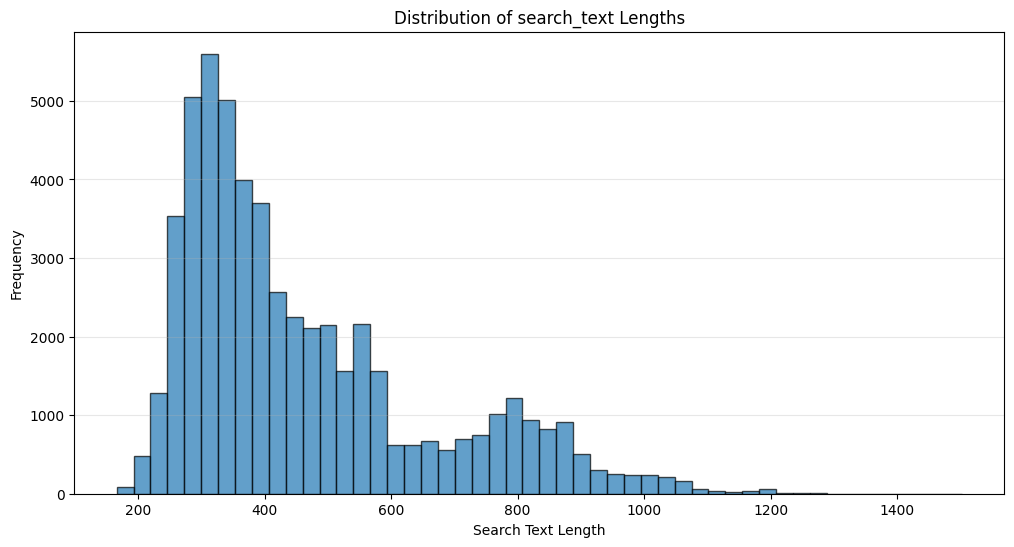

Mean length: 462.5
Median length: 393
Std dev: 198.4


In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Search Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of search_text Lengths')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print some statistics
print(f"Mean length: {sum(lengths) / len(lengths):.1f}")
print(f"Median length: {sorted(lengths)[len(lengths)//2]}")
print(f"Std dev: {(sum((x - sum(lengths)/len(lengths))**2 for x in lengths) / len(lengths))**0.5:.1f}")
